# **Week 2: Lab Exercises for COMP499/691 Conversational AI**

The goal of this lab is to familiarize yourself with SpeechBrain and its coding style.  Before starting, you should have read our basic tutorials (https://speechbrain.github.io/).

## **Exercise 1: Train an audio digit classifier**

In this lab, you are going to write a full recipe in SpeechBrain. What we call *“recipe”* is the set of all the scripts (data preparation, training, hyperparameters) needed to train some model with some dataset.

In this case, we will work on audio digit recognition using the [audio MNIST dataset](https://www.kaggle.com/datasets/alanchn31/free-spoken-digits). The input is a speech recording of a spoken digit, while the output is the corresponding number (between 0 and 9).



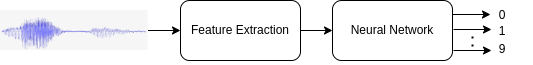

**Run the code below** to install SpeechBrain:


In [1]:
%%capture
!pip install speechbrain

If everything works well, you should be able to import speechbrain like this:

In [2]:
import speechbrain

Let's also import some libraries that will be useful later

In [3]:
import torch
import torchaudio
import matplotlib.pyplot as plt
from IPython.display import Audio
torch.manual_seed(2023)

**Run the code below** to download the audio MNIST dataset. The dataset is quite big (downloading it might take a few minutes).

In [4]:
!git clone https://github.com/soerenab/AudioMNIST /content/AudioMNIST

Cloning into '/content/AudioMNIST'...
remote: Enumerating objects: 30128, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 30128 (delta 3), reused 0 (delta 0), pack-reused 30119
Receiving objects: 100% (30128/30128), 944.54 MiB | 18.83 MiB/s, done.
Resolving deltas: 100% (29/29), done.
Updating files: 100% (30018/30018), done.


[link text](https://)### **Exercise 1.1. Data Inspection**

Before starting, let's inspect a few data to ensure everything is fine.

**Write the code** to load a signal (i.e., `/content/AudioMNIST/data/01/0_01_0.wav`) using torchaudio. Print the audio shape and the sampling frequency. Plot the signal using matplotlib (take care of the audio shape before plotting it) and play it with Audio (see the speechbrain introduction tutorial to see an example of how to play signals with Audio).


torch.Size([1, 35877])
48000




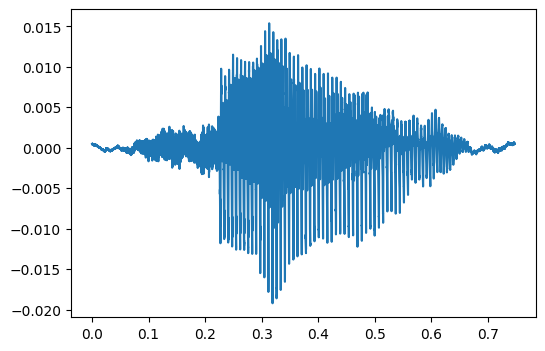

In [5]:
# Your code here

from torchaudio.transforms import Resample
from speechbrain.dataio.dataio import read_audio

# Print the audio shape and sampling frequency
def print_audio_info(waveform, sample_rate):
    print(waveform.shape)
    print(sample_rate)
    print('\n')

# Load the audio file
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    print_audio_info(waveform, sample_rate)
    return waveform, sample_rate

# Plot the signal
def plot_audio_signal(waveform, sample_rate):
    time = torch.arange(0, waveform.size(1)) / sample_rate
    plt.figure(figsize=(6, 4))
    plt.plot(time.numpy(), waveform.t().numpy())
    plt.show()
    print('\n')

audio_file_location = '/content/AudioMNIST/data/01/0_01_0.wav'

waveform, sample_rate = load_audio(audio_file_location)
plot_audio_signal(waveform, sample_rate)
signal = read_audio(audio_file_location).squeeze()
Audio(signal, rate=sample_rate)


If everything is fine, you should get the following output:

```
torch.Size([1, 35877])
48000

```



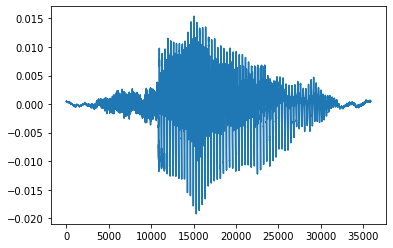

Let's open another digit: `/content/AudioMNIST/data/60/9_60_9.wav`


**Write the code** to load another signal (i.e., `/content/AudioMNIST/data/60/9_60_9.wav`) using torchaudio. Print the audio shape and the sampling frequency. Plot the signal using matplotlib (take care of the audio shape before plotting it) and play it with Audio (see the speechbrain introduction tutorial to see an example of how to play signals with Audio).


torch.Size([1, 34304])
48000




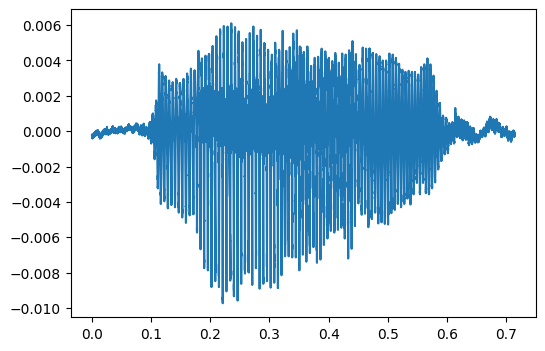

In [6]:
# Your code here

audio_file_location = '/content/AudioMNIST/data/60/9_60_9.wav'

waveform, sample_rate = load_audio(audio_file_location)
plot_audio_signal(waveform, sample_rate)
signal = read_audio(audio_file_location).squeeze()
Audio(signal, rate=sample_rate)

You should see the following:

```
torch.Size([1, 34304])
48000

```



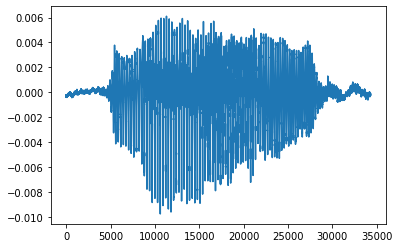

Please, be aware of the following:

*   The sampling frequency is 48 kHz. This rate is pretty high. Normally, working at 16 kHz is enough. We will downsample the signals on-the-fly n the training script directly.

*  Each signal has a different shape. This is expected for audio signals because the signal varies in their length. SpeechBrain will create batches using random sentences and apply zero padding to match the longest sentence in the batch.

* If you analyze the path of the audio signal, you can already retrieve the corresponding label. *Could you guess it?*


###**Exercise 1.2. Data Preparation**

The goal of this step is to create the data manifest files (in CSV format) that SpeechBrain expects in input. These files tell SpeechBrain where to find the speech data and their corresponding labels for the training, validation, and test sets.


First, let's get all the audio files into a list.

**Complete the code below** to get a list of all the wav files in the `AudioMNIST/data` folder. Use the function [get_all_files](https://speechbrain.readthedocs.io/en/latest/API/speechbrain.utils.data_utils.html#speechbrain.utils.data_utils.get_all_files) from speechbrain.

In [7]:
from speechbrain.utils.data_utils import get_all_files

audiofiles = get_all_files('AudioMNIST/data')

print(len(audiofiles))

30001


If everything is fine, you should have 30000 files.

The number of files is quite high and can make training slower. Just for this tutorial, we select a subset of it.

In particular, we split the dataset in this way:
- `training` with speakers from 1 to 10.
- `validation` with speakers from 11 to 14.
- `test` with speakers from 15 to 18.

**Complete the code below** to split the data as mentioned above.

In [8]:
train_speakers = ['/01/','/02/','/03/','/04/','/05/','/06/','/07/','/08/','/09/','/10/']
valid_speakers = ['/11/','/12/','/13/','/14/']
test_speakers = ['/15/','/16/','/17/','/18/']

def split_data(audiofiles, spks):
  """This function takes in input a list of audio files and returns a list
  containing only files from the given list of speakers."""
  # Your code here. Aim for 5-6 lines
  new_list = []
  for file in audiofiles:
    for spk in spks:
      if spk in file:
        new_list.append(file)
        break
  return new_list

# Splitting data
train_files = split_data(audiofiles, train_speakers)
valid_files = split_data(audiofiles, valid_speakers)
test_files = split_data(audiofiles, test_speakers)

If everything is fine, you should have 5000 (training), 2000 (validation), and 2000 (test) files.

Now, we can create the data-manifest files in JSON format for all these subsets.

**Complete the code below** to create the data-manifest files. You can get the information needed to compute the duration in seconds (mandatory field) from `torchaudio.info`. Remember: the duration is the length of the signal divided by the sample rate. You also have to assign a unique id to each sentence. You can get the digit label from the audio path itself.

*Running the code below might take a few minitues.*

In [9]:
import json

def create_json(json_file, audiolist):
  json_dict = {}
  for audiofile in audiolist:

    # Getting info
    audioinfo = torchaudio.info(audiofile) # Your code here

    # Compute the duration in seconds.
    # This is the number of samples divided by the sampling frequency
    duration = audioinfo.num_frames / audioinfo.sample_rate # Your code here

    # Get digit Label by manipulating the audio path
    digit = audiofile[19] # Your code here (aim for 1 line)_

    # Get a unique utterance id
    uttid = audiofile[19:] # Your code here (aim for 1 line)

    # Create entry for this utterance
    json_dict[uttid] = {
            "wav": audiofile,
            "length": duration,
            "digit": digit,
    }

    # Writing the dictionary to the json file
    with open(json_file, mode="w") as json_f:
      json.dump(json_dict, json_f, indent=2)



create_json('train.json', train_files)
create_json('valid.json', valid_files)
create_json('test.json', test_files)

If everything is fine, the first two entries of the JSON files should look like this:


**train.json**
```
{
  "6_10_30.wav": {
    "wav": "AudioMNIST/data/10/6_10_30.wav",
    "length": 0.7466041666666666,
    "digit": "6"
  },
  "4_10_22.wav": {
    "wav": "AudioMNIST/data/10/4_10_22.wav",
    "length": 0.6258125,
    "digit": "4"
  },
  ........
```

**valid.json**

```
{
  "8_13_43.wav": {
    "wav": "AudioMNIST/data/13/8_13_43.wav",
    "length": 0.6086041666666666,
    "digit": "8"
  },
  "9_13_41.wav": {
    "wav": "AudioMNIST/data/13/9_13_41.wav",
    "length": 0.8174166666666667,
    "digit": "9"
  },
  ........
```

**test.json**


```
{
  "9_17_16.wav": {
    "wav": "AudioMNIST/data/17/9_17_16.wav",
    "length": 0.6987708333333333,
    "digit": "9"
  },
  "3_17_20.wav": {
    "wav": "AudioMNIST/data/17/3_17_20.wav",
    "length": 0.6341458333333333,
    "digit": "3"
  },
  ........
```




###**Exercise 1.3. Training**

We can now proceed with training. In particular, we want to train our digit classifier with an [xvector-based model](https://www.danielpovey.com/files/2018_icassp_xvectors.pdf).

This model extracts embeddings using an [time-delay neural network (TDNN)](https://en.wikipedia.org/wiki/Time_delay_neural_network).

To get embeddings of fixed size out of variable size audio recordings, it uses statistics pooling.  
The statistics pooling layer aggregates all frame-level latent representations from the encoder layer and computes their mean and standard deviations.

On top of the aforementioned fixed-size embeddings, a simple MLP classifier is applied.

The xvector model is implemented in speechbrain [here](https://github.com/speechbrain/speechbrain/blob/develop/speechbrain/lobes/models/Xvector.py).

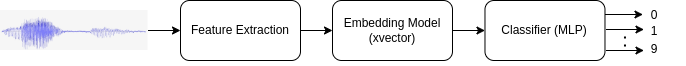

**Run the code below** to store the hyperparameter file that defines the xvector-based digit classifier. Take a look at the adopted hyperparameters.
As you can see, we use 40 fbanks, and we normalize their mean and variance.
The system iterates for 10 epochs with a batch size of 64. The learning rate starts at 0.001, and is annealed linearly over the epochs to reach 0.0001 at the end of training.


In [10]:
%%file hparams_xvector.yaml

# #################################
# Basic training parameters for digit classification with Xvector
#
# Author:
#  * Mirco Ravanelli 2021
# #################################

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

output_folder: !ref ./results/AudioMNIST/Xvector/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: train.json
valid_annotation: valid.json
test_annotation: test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 10
batch_size: 64
lr_start: 0.001
lr_final: 0.0001
n_classes: 10 # In this case, we have 10 digits
emb_dim: 128 # dimensionality of the embeddings
dataloader_options:
    batch_size: !ref <batch_size>

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Embedding model: from variable size digits gets a fixed size embedding vector
embedding_model: !new:speechbrain.lobes.models.Xvector.Xvector
    in_channels: !ref <n_mels>
    activation: !name:torch.nn.LeakyReLU
    tdnn_blocks: 5
    tdnn_channels: [64, 64, 64, 64, 128]
    tdnn_kernel_sizes: [5, 3, 3, 1, 1]
    tdnn_dilations: [1, 2, 3, 1, 1]
    lin_neurons: !ref <emb_dim>

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <emb_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model: !ref <embedding_model>
    classifier: !ref <classifier>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>

Writing hparams_xvector.yaml


Now, we need to work on the training script itself (train.py).

**Complete the code below** and start training a model. In particular, you should write your code for the `compute_foward` and `compute objective` methods.
You can draw inspiration from the tutorial seen in the lab session. Moreover, you have to complete the code in the `audio_pipeline` function and add the resampling function to downsample the signal to 16 kHz. You can use `torchaudio.functional.resample` (make sure the dimensionality of the returned signal matches with the expected format: `[batch, time]`).





In [11]:
%%file train.py

#!/usr/bin/env python3
"Recipe for training a digit classification system."
import os
import sys
import torch
import torchaudio
import speechbrain as sb
from hyperpyyaml import load_hyperpyyaml


# Brain class for speech enhancement training
class DigitBrain(sb.Brain):
    """Class that manages the training loop. See speechbrain.core.Brain."""

    def compute_forward(self, batch, stage):
        """Runs all the computations that transforms the input into the
        output probabilities over the N classes.

        Arguments
        ---------
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        predictions : Tensor
            Tensor that contains the posterior probabilities over the N classes.
        """
        # Your code here. Aim for 7-8 lines
        # We first move the batch to the appropriate device.
        batch = batch.to(self.device)

        # Compute features, embeddings, and predictions
        feats, lens = self.prepare_features(batch, stage)

        embeddings = self.modules.embedding_model(feats, lens)
        predictions = self.modules.classifier(embeddings)

        return predictions


    def compute_objectives(self, predictions, batch, stage):
        """Computes the loss given the predicted and targeted outputs.

        Arguments
        ---------
        predictions : tensor
            The output tensor from `compute_forward`.
        batch : PaddedBatch
            This batch object contains all the relevant tensors for computation.
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        Returns
        -------
        loss : torch.Tensor
            A one-element tensor used for backpropagating the gradient.
        """

        # Your code here. Aim for 7-8 lines
        _, lens = batch.sig
        digit, _ = batch.digit_encoded

        # Compute the cost function
        loss = sb.nnet.losses.nll_loss(predictions, digit, lens)

        # Append this batch of losses to the loss metric for easy
        self.loss_metric.append(
            batch.id, predictions, digit, lens, reduction="batch"
        )

        # Compute classification error at test time
        if stage != sb.Stage.TRAIN:
            self.error_metrics.append(batch.id, predictions, digit, lens)
        return loss

    def prepare_features(self, wavs, stage):
        """Prepare the features for computation, including augmentation.
        Arguments
        ---------
        wavs : tuple
            Input signals (tensor) and their relative lengths (tensor).
        stage : sb.Stage
            The current stage of training.
        """
        wavs, lens = wavs.sig

        # Feature extraction and normalization
        feats = self.modules.compute_features(wavs)
        feats = self.modules.mean_var_norm(feats, lens)

        return feats, lens

    def on_stage_start(self, stage, epoch=None):
        """Gets called at the beginning of each epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, or sb.Stage.TEST.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Set up statistics trackers for this stage
        self.loss_metric = sb.utils.metric_stats.MetricStats(
            metric=sb.nnet.losses.nll_loss
        )

        # Set up evaluation-only statistics trackers
        if stage != sb.Stage.TRAIN:
            self.error_metrics = self.hparams.error_stats()

    def on_stage_end(self, stage, stage_loss, epoch=None):
        """Gets called at the end of an epoch.
        Arguments
        ---------
        stage : sb.Stage
            One of sb.Stage.TRAIN, sb.Stage.VALID, sb.Stage.TEST
        stage_loss : float
            The average loss for all of the data processed in this stage.
        epoch : int
            The currently-starting epoch. This is passed
            `None` during the test stage.
        """

        # Store the train loss until the validation stage.
        if stage == sb.Stage.TRAIN:
            self.train_loss = stage_loss

        # Summarize the statistics from the stage for record-keeping.
        else:
            stats = {
                "loss": stage_loss,
                "error": self.error_metrics.summarize("average"),
            }

        # At the end of validation...
        if stage == sb.Stage.VALID:

            old_lr, new_lr = self.hparams.lr_annealing(epoch)
            sb.nnet.schedulers.update_learning_rate(self.optimizer, new_lr)

            # The train_logger writes a summary to stdout and to the logfile.
            self.hparams.train_logger.log_stats(
                {"Epoch": epoch, "lr": old_lr},
                train_stats={"loss": self.train_loss},
                valid_stats=stats,
            )

            # Save the current checkpoint and delete previous checkpoints,
            self.checkpointer.save_and_keep_only(meta=stats, min_keys=["error"])

        # We also write statistics about test data to stdout and to the logfile.
        if stage == sb.Stage.TEST:
            self.hparams.train_logger.log_stats(
                {"Epoch loaded": self.hparams.epoch_counter.current},
                test_stats=stats,
            )


def dataio_prep(hparams):
    """This function prepares the datasets to be used in the brain class.
    It also defines the data processing pipeline through user-defined functions.
    We expect `prepare_mini_librispeech` to have been called before this,
    so that the `train.json`, `valid.json`,  and `valid.json` manifest files
    are available.
    Arguments
    ---------
    hparams : dict
        This dictionary is loaded from the `train.yaml` file, and it includes
        all the hyperparameters needed for dataset construction and loading.
    Returns
    -------
    datasets : dict
        Contains two keys, "train" and "valid" that correspond
        to the appropriate DynamicItemDataset object.
    """

    # Initialization of the label encoder. The label encoder assigns to each
    # of the observed label a unique index (e.g, 'digit0': 0, 'digit1': 1, ..)
    label_encoder = sb.dataio.encoder.CategoricalEncoder()

    # Define audio pipeline
    @sb.utils.data_pipeline.takes("wav")
    @sb.utils.data_pipeline.provides("sig")
    def audio_pipeline(wav):
        """Load the signal, and pass it and its length to the corruption class.
        This is done on the CPU in the `collate_fn`."""

        sig, fs = torchaudio.load(wav)

        # Resampling
        sig = sb.dataio.dataio.read_audio(wav) # Your code here. Aim for 1-2 lines
        sig = torchaudio.functional.resample(waveform=sig, orig_freq=fs, new_freq=16000)
        return sig

    # Define label pipeline:
    @sb.utils.data_pipeline.takes("digit")
    @sb.utils.data_pipeline.provides("digit", "digit_encoded")
    def label_pipeline(digit):
        """Defines the pipeline to process the digit labels.
        Note that we have to assign a different integer to each class
        through the label encoder.
        """
        yield digit
        digit_encoded = label_encoder.encode_label_torch(digit)
        yield digit_encoded

    # Define datasets. We also connect the dataset with the data processing
    # functions defined above.
    datasets = {}
    data_info = {
        "train": hparams["train_annotation"],
        "valid": hparams["valid_annotation"],
        "test": hparams["test_annotation"],
    }
    hparams["dataloader_options"]["shuffle"] = True
    for dataset in data_info:
        datasets[dataset] = sb.dataio.dataset.DynamicItemDataset.from_json(
            json_path=data_info[dataset],
            dynamic_items=[audio_pipeline, label_pipeline],
            output_keys=["id", "sig", "digit_encoded"],
        )

    # Load or compute the label encoder (with multi-GPU DDP support)
    # Please, take a look into the lab_enc_file to see the label to index
    # mapping.
    lab_enc_file = os.path.join(hparams["save_folder"], "label_encoder.txt")
    label_encoder.load_or_create(
        path=lab_enc_file,
        from_didatasets=[datasets["train"]],
        output_key="digit",
    )

    return datasets


# Recipe begins!
if __name__ == "__main__":

    # Reading command line arguments.
    hparams_file, run_opts, overrides = sb.parse_arguments(sys.argv[1:])

    # Load hyperparameters file with command-line overrides.
    with open(hparams_file) as fin:
        hparams = load_hyperpyyaml(fin,  overrides)

    # Create experiment directory
    sb.create_experiment_directory(
        experiment_directory=hparams["output_folder"],
        hyperparams_to_save=hparams_file,
        overrides=overrides,
    )

    # Create dataset objects "train", "valid", and "test".
    datasets = dataio_prep(hparams)

    # Initialize the Brain object to prepare for mask training.
    digit_brain = DigitBrain(
        modules=hparams["modules"],
        opt_class=hparams["opt_class"],
        hparams=hparams,
        run_opts=run_opts,
        checkpointer=hparams["checkpointer"],
    )

    # The `fit()` method iterates the training loop, calling the methods
    # necessary to update the parameters of the model. Since all objects
    # with changing state are managed by the Checkpointer, training can be
    # stopped at any point, and will be resumed on next call.
    digit_brain.fit(
        epoch_counter=digit_brain.hparams.epoch_counter,
        train_set=datasets["train"],
        valid_set=datasets["valid"],
        train_loader_kwargs=hparams["dataloader_options"],
        valid_loader_kwargs=hparams["dataloader_options"],
    )

    # Load the best checkpoint for evaluation
    test_stats = digit_brain.evaluate(
        test_set=datasets["test"],
        min_key="error",
        test_loader_kwargs=hparams["dataloader_options"],
    )


Writing train.py


**Run the code below** to train the model.


In [12]:
# Delete the output folder to start training from scratch
# (and not from a previous checkpoint).
!rm -rf results/AudioMNIST/Xvector/1986

# Run training
!python train.py hparams_xvector.yaml

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./results/AudioMNIST/Xvector/1986
speechbrain.dataio.encoder - Load called, but CategoricalEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.core - 102.0k trainable parameters in DigitBrain
speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
speechbrain.utils.epoch_loop - Going into epoch 1
  0% 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/speechbrain/dataio/encoder.py:722: UserWarning: CategoricalEncoder.expect_len was never called: assuming category count of 10 to be correct! Sanity check your encoder using `.expect_len`. Ensure that downstream code also uses the correct size. If you are sure this does not apply to you, use `.ignore_len`.
  warnings.warn(
100% 79/79 [01:30<00:00,  1.15s/it, train_loss=0.282]
100% 32/32 [00:35<00:00,  1.11s/it]
speechbrain.nnet.schedulers - Chan

If  everything is fine, the training logs (see `results/AudioMNIST/Xvector/1986/train_log.txt`) should look like this:





```
Epoch: 1, lr: 1.00e-03 - train loss: 2.57e-01 - valid loss: 3.42e-01, valid error: 1.20e-01
Epoch: 2, lr: 9.00e-04 - train loss: 1.60e-02 - valid loss: 2.20e-01, valid error: 7.00e-02
Epoch: 3, lr: 8.00e-04 - train loss: 1.91e-02 - valid loss: 4.19e-01, valid error: 1.14e-01
Epoch: 4, lr: 7.00e-04 - train loss: 6.26e-03 - valid loss: 2.68e-01, valid error: 6.00e-02
Epoch: 5, lr: 6.00e-04 - train loss: 6.53e-03 - valid loss: 3.46e-01, valid error: 1.05e-01
Epoch: 6, lr: 5.00e-04 - train loss: 2.03e-03 - valid loss: 2.11e-01, valid error: 5.70e-02
Epoch: 7, lr: 4.00e-04 - train loss: 1.42e-03 - valid loss: 2.23e-01, valid error: 5.70e-02
Epoch: 8, lr: 3.00e-04 - train loss: 2.45e-03 - valid loss: 2.05e-01, valid error: 5.05e-02
Epoch: 9, lr: 2.00e-04 - train loss: 1.54e-03 - valid loss: 2.01e-01, valid error: 5.10e-02
Epoch: 10, lr: 1.00e-04 - train loss: 1.56e-03 - valid loss: 1.97e-01, valid error: 4.85e-02
Epoch loaded: 10 - test loss: 1.40e-01, test error: 5.20e-02
```



Note that it is fine if you obtain training logs that are a bit different. Also, the convergence might be a bit "turbulent" for this model, in the sense that the validation error might oscillate a lot.
The most important thing is that the network is converging and that the test_error is good (e.g., < 7%).

###**Exercise 1.4 Training with a user-defined model**

We now would like to define a new model and use it to train our digit classifier.  In particular, we want to implement the following combination of CNN and RNN models:

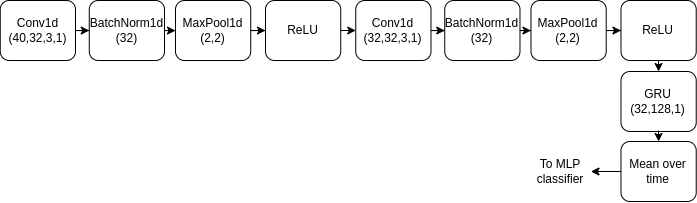

As you can see, we have two convolutional layers followed by a Gated Recurrent Unit (GRU). After that, we need to add a layer that averages the embeddings over time. This way, just like the xvector, we can have fixed-size embeddings whose dimensionality does not depend on the time axis.

Note that the numbers in each block correspond to the hyperparameters to use (in the given order). For instance, in the first conv1d block you see (40,32,3,1). This corresponds to the number of input channels, output channels, kernel_size, and stride factor, respectively (as in https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html).

**Complete the code below** to implement this model.

In [13]:
%%file CRNN.py

import math
import torch
from speechbrain.dataio.dataio import length_to_mask
import torch.nn as nn


class CRNN(torch.nn.Module):
  def __init__(self,in_channels=40, emb_dim=128):
    super(CRNN,self).__init__()

    # Your code here. Aim for 9-10 lines. Use the sequential container.
    # Convolutional Block
    #self.cnn = # Your code here
    self.cnn = nn.Sequential(
      nn.Conv1d(40, 32, 3, 1),
      nn.BatchNorm1d(32),
      nn.MaxPool1d(2, 2),
      nn.ReLU(),
      nn.Conv1d(32, 32, 3, 1),
      nn.BatchNorm1d(32),
      nn.MaxPool1d(2, 2),
      nn.ReLU()
    )

    # Recurrent Block. Aim for 1 line
    self.rnn = nn.GRU(32, 128, 1) # Your code here

  def forward(self,x, lens):

    # Your code here. Aim for 3-5 lines. Take care of the dimensionalities required
    # by each block. You need to transpose/reshape the tensors properly
    x = torch.transpose(x, 1, 2) # Your code here
    x = self.cnn(x)

    x = torch.transpose(x, 1, 2)
    x = self.rnn(x)
    x = x[0] # GRU returns a tuple(output tensor, final hidden state)

    # Mean Computation. Here we average all the time steps. Note that we remove
    # the zero-padded time steps using a mask.
    abs_len = (lens * x.shape[1]).int()
    mask = length_to_mask(abs_len)
    masked_x = x * mask.unsqueeze(2)
    emb = masked_x.sum(dim=1)/mask.sum(dim=1, keepdim=True)
    return emb.unsqueeze(1)

Writing CRNN.py


**Run the code below** to test the model.

In [14]:
# Importing the library from the file.
# This is reloaded every time to allow modifications of library file.
import importlib
import CRNN
importlib.reload(CRNN)
from CRNN import CRNN

# Example
input = torch.rand(16,120,40)
model = CRNN()
output = model(input,torch.ones(16))
print(output.shape)

torch.Size([16, 1, 128])


If everything is fine, you should get the following output shape:

`torch.Size([16, 1, 128])`

Now, you have to write the new hyperparameter file.

**Write the hyperpameter YAML file** for your new model. You can copy and paste the xvector one and do the few modifications needed to import the new model.
In particular:
- change the output folder to `/results/AudioMNIST/CRNN/<seed>`
- replace the xvector embedding_model with the CRNN one. Keep calling it `embedding_model `. This way, we can reuse the same train.py as before without any modification. You can use the same MLP classifier as before.

In [15]:
%%writefile hparams_CRNN.yaml

# Your Code Here

# Seed needs to be set at top of yaml, before objects with parameters are made
seed: 1986
__set_seed: !!python/object/apply:torch.manual_seed [!ref <seed>]

output_folder: !ref ./results/AudioMNIST/CRNN/<seed>
save_folder: !ref <output_folder>/save
train_log: !ref <output_folder>/train_log.txt

# Path where data manifest files are stored
train_annotation: train.json
valid_annotation: valid.json
test_annotation: test.json

# The train logger writes training statistics to a file, as well as stdout.
train_logger: !new:speechbrain.utils.train_logger.FileTrainLogger
    save_file: !ref <train_log>

error_stats: !name:speechbrain.utils.metric_stats.MetricStats
    metric: !name:speechbrain.nnet.losses.classification_error
        reduction: batch

# Feature parameters
n_mels: 40

# Training Parameters
sample_rate: 16000
number_of_epochs: 10
batch_size: 64
lr_start: 0.001
lr_final: 0.0001
n_classes: 10 # In this case, we have 10 digits
emb_dim: 128 # dimensionality of the embeddings
dataloader_options:
    batch_size: !ref <batch_size>

# Feature extraction
compute_features: !new:speechbrain.lobes.features.Fbank
    n_mels: !ref <n_mels>

# Mean and std normalization of the input features
mean_var_norm: !new:speechbrain.processing.features.InputNormalization
    norm_type: global

# Embedding model: from variable size digits gets a fixed size embedding vector
embedding_model: !new:CRNN.CRNN
    in_channels: !ref <n_mels>
    # activation: !name:torch.nn.LeakyReLU
    # tdnn_blocks: 5
    # tdnn_channels: [64, 64, 64, 64, 128]
    # tdnn_kernel_sizes: [5, 3, 3, 1, 1]
    # tdnn_dilations: [1, 2, 3, 1, 1]
    # lin_neurons: !ref <emb_dim>

# Clasifier applied on top of the embeddings
classifier: !new:speechbrain.lobes.models.Xvector.Classifier
    input_shape: [null, null, !ref <emb_dim>]
    activation: !name:torch.nn.LeakyReLU
    lin_blocks: 1
    lin_neurons: !ref <emb_dim>
    out_neurons: !ref <n_classes>

# The first object passed to the Brain class is this "Epoch Counter"
# which is saved by the Checkpointer so that training can be resumed
# if it gets interrupted at any point.
epoch_counter: !new:speechbrain.utils.epoch_loop.EpochCounter
    limit: !ref <number_of_epochs>

# Objects in "modules" dict will have their parameters moved to the correct
# device, as well as having train()/eval() called on them by the Brain class.
modules:
    compute_features: !ref <compute_features>
    mean_var_norm: !ref <mean_var_norm>
    embedding_model: !ref <embedding_model>
    classifier: !ref <classifier>

# This optimizer will be constructed by the Brain class after all parameters
# are moved to the correct device. Then it will be added to the checkpointer.
opt_class: !name:torch.optim.Adam
    lr: !ref <lr_start>

# This function manages learning rate annealing over the epochs.
# We here use the simple lr annealing method that linearly decreases
# the lr from the initial value to the final one.
lr_annealing: !new:speechbrain.nnet.schedulers.LinearScheduler
    initial_value: !ref <lr_start>
    final_value: !ref <lr_final>
    epoch_count: !ref <number_of_epochs>

# This object is used for saving the state of training both so that it
# can be resumed if it gets interrupted, and also so that the best checkpoint
# can be later loaded for evaluation or inference.
checkpointer: !new:speechbrain.utils.checkpoints.Checkpointer
    checkpoints_dir: !ref <save_folder>
    recoverables:
        embedding_model: !ref <embedding_model>
        classifier: !ref <classifier>
        normalizer: !ref <mean_var_norm>
        counter: !ref <epoch_counter>

Writing hparams_CRNN.yaml


**Run the code below** to train the model.

In [16]:
# Delete the output folder to start training from scratch
# (and not from a previous checkpoint).
!rm -rf results/AudioMNIST/CRNN/1986

# Run training
!python train.py hparams_CRNN.yaml

speechbrain.core - Beginning experiment!
speechbrain.core - Experiment folder: ./results/AudioMNIST/CRNN/1986
speechbrain.dataio.encoder - Load called, but CategoricalEncoder is not empty. Loaded data will overwrite everything. This is normal if there is e.g. an unk label defined at init.
speechbrain.core - 87.6k trainable parameters in DigitBrain
speechbrain.utils.checkpoints - Would load a checkpoint here, but none found yet.
speechbrain.utils.epoch_loop - Going into epoch 1
  0% 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/speechbrain/dataio/encoder.py:722: UserWarning: CategoricalEncoder.expect_len was never called: assuming category count of 10 to be correct! Sanity check your encoder using `.expect_len`. Ensure that downstream code also uses the correct size. If you are sure this does not apply to you, use `.ignore_len`.
  warnings.warn(
100% 79/79 [01:23<00:00,  1.06s/it, train_loss=0.597]
100% 32/32 [00:38<00:00,  1.19s/it]
speechbrain.nnet.schedulers - Changing

If everything works, the training log file should look like this:


```
Epoch: 1, lr: 1.00e-03 - train loss: 6.09e-01 - valid loss: 7.75e-01, valid error: 2.03e-01
Epoch: 2, lr: 9.00e-04 - train loss: 5.61e-02 - valid loss: 7.53e-01, valid error: 1.62e-01
Epoch: 3, lr: 8.00e-04 - train loss: 2.76e-02 - valid loss: 8.11e-01, valid error: 1.72e-01
Epoch: 4, lr: 7.00e-04 - train loss: 1.60e-02 - valid loss: 7.71e-01, valid error: 1.51e-01
Epoch: 5, lr: 6.00e-04 - train loss: 1.10e-02 - valid loss: 7.70e-01, valid error: 1.52e-01
Epoch: 6, lr: 5.00e-04 - train loss: 9.15e-03 - valid loss: 7.36e-01, valid error: 1.46e-01
Epoch: 7, lr: 4.00e-04 - train loss: 9.67e-03 - valid loss: 6.76e-01, valid error: 1.31e-01
Epoch: 8, lr: 3.00e-04 - train loss: 5.59e-03 - valid loss: 6.71e-01, valid error: 1.27e-01
Epoch: 9, lr: 2.00e-04 - train loss: 4.43e-03 - valid loss: 7.09e-01, valid error: 1.32e-01
Epoch: 10, lr: 1.00e-04 - train loss: 3.52e-03 - valid loss: 7.46e-01, valid error: 1.35e-01
Epoch loaded: 8 - test loss: 2.97e-01, test error: 1.01e-01

```

Note that the variability is pretty high for this task (depending on the run you can achive errors between 10 and 5%). The previous xvector model, which is much more complex than this simple one, generally (but not always) provides better performance.

That's all for this lab!